In [26]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, jit, value_and_grad

In [27]:
@jit
def loss(mu,v):
    b1 = 0.8; b2 = 0.01;
    a1 = 2.0; a2 = 5.0;
    ls = b1*(mu**2+v - 2.0*a1*mu + a1**2) + b2*( (mu**3+3.0*mu*v) - 3.0*a2*(mu**2+v) + 3.0*(a2**2)*mu - a2**3 ) +4.0/v
    return ls

@jit
def loss_pre(params):
    (mu,s) = params
    return loss(mu,1.0/s) + jnp.log(s)/2

loss_f_pre = jit(value_and_grad(loss_pre))

In [28]:
def gd(init_params, loss_fun, step_size, num_iters):


    J_history = np.zeros(num_iters+1)
    mu_hist, s_hist = np.zeros(num_iters+1), np.zeros(num_iters+1) #For plotting afterwards  
    
    cur_params = init_params
    for i in range(num_iters):
        
        (val,g) = loss_fun(cur_params)
        mu_hist[i] = cur_params[0]
        s_hist[i] = cur_params[1] 
        J_history[i] = val
        
        #GD
        cur_params  = cur_params - step_size* g

        
    (val,_) = loss_fun(cur_params)
    J_history[num_iters] = val
    mu_hist[num_iters] = cur_params[0]
    s_hist[num_iters] = cur_params[1] 

    return J_history, mu_hist, s_hist

In [29]:
def ngd_pre(init_params, loss_fun, step_size, num_iters):

    J_history = np.zeros(num_iters+1)
    mu_hist, s_hist = np.zeros(num_iters+1), np.zeros(num_iters+1) #For plotting afterwards  
    
    cur_params = init_params
    for i in range(num_iters):
        (mu,s)=cur_params
        (val,(g_mu,g_s)) = loss_fun(cur_params)
        ng = jnp.array( [g_mu/s, 2.0*(s**2)*g_s ] )

        mu_hist[i] = cur_params[0]
        s_hist[i] = cur_params[1] 
        J_history[i] = val
        
        #NGD
        cur_params  = cur_params - step_size* ng

        
    (val,_) = loss_fun(cur_params)
    J_history[num_iters] = val
    mu_hist[num_iters] = cur_params[0]
    s_hist[num_iters] = cur_params[1] 

    return J_history, mu_hist, s_hist

In [30]:
#Setup of meshgrid of theta values
mu_list, s_list = np.meshgrid(np.linspace(-10,10,200),np.logspace(-1,0.2,800))

#Computing the cost function for each theta combination
zs = np.array(  [loss_pre( jnp.array([mu,s]) ) 
                     for mu,s in zip(np.ravel(mu_list), np.ravel(s_list)) ] )

zs = zs   #- np.min(zs) + 1e-6
Z = zs.reshape(mu_list.shape)

In [31]:
mu_0 = -8.0
s_0 = 1.0
max_num_iters = 200
init_params = jnp.array([mu_0,s_0])
gd_pre_history, mu_gd_pre_hist, s_gd_pre_hist = gd(init_params, loss_f_pre, step_size = 1e-2, num_iters=max_num_iters)
anglesx_gd_pre = np.array(mu_gd_pre_hist)[1:] - np.array(mu_gd_pre_hist)[:-1]
anglesy_gd_pre = np.array(s_gd_pre_hist)[1:] - np.array(s_gd_pre_hist)[:-1]

In [32]:
mu_0 = -8.0
s_0 = 1.0
max_num_iters = 200
init_params = jnp.array([mu_0,s_0])
ngd_pre_history, mu_ngd_pre_hist, s_ngd_pre_hist = ngd_pre(init_params, loss_f_pre, step_size = 1e-2, num_iters=max_num_iters)
anglesx_ngd_pre = np.array(mu_ngd_pre_hist)[1:] - np.array(mu_ngd_pre_hist)[:-1]
anglesy_ngd_pre = np.array(s_ngd_pre_hist)[1:] - np.array(s_ngd_pre_hist)[:-1]

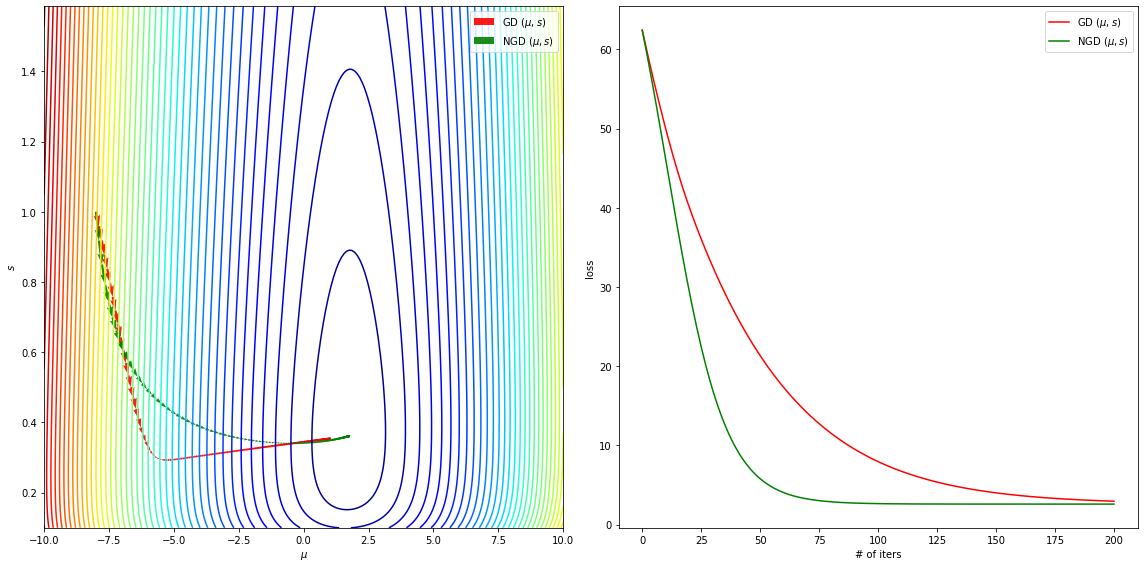

In [34]:
%matplotlib inline
from matplotlib import ticker, colors
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)

#Contour plot
ax.contour(mu_list, s_list, Z, 50, cmap = 'jet')

ax.quiver(mu_gd_pre_hist[:-1], s_gd_pre_hist[:-1], anglesx_gd_pre, anglesy_gd_pre, label='GD $(\mu,s)$', scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)

ax.quiver(mu_ngd_pre_hist[:-1], s_ngd_pre_hist[:-1], anglesx_ngd_pre, anglesy_ngd_pre, label='NGD $(\mu,s)$', scale_units = 'xy', angles = 'xy', scale = 1, color = 'g', alpha = .9)

ax.set_xlabel('$\mu$')
ax.set_ylabel('$s$')
ax.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.array(list(range(0, max_num_iters+1))),gd_pre_history,label='GD $(\mu,s)$',color='r')
ax.plot(np.array(list(range(0, max_num_iters+1))),ngd_pre_history,label='NGD $(\mu,s)$',color='g')
ax.legend(loc='upper right')
ax.set_xlabel('# of iters')
ax.set_ylabel('loss')

plt.tight_layout()
plt.show()